In [ ]:
# Adversarial Patch Generation for Face Recognition
# Google Colab Notebook - Complete Pipeline with Custom Person Selection

"""
This notebook implements adversarial patch generation to fool face recognition systems.
It trains patches that can make an attacker be misidentified as a target employee.

Pipeline:
1. Setup environment and install dependencies
2. Load LFW dataset
3. Build face recognition model and employee database
4. Generate adversarial patches
5. Test patches and export results
"""

# ============================================================================
# CELL 1: Setup and Dependencies
# ============================================================================

!pip install -q torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu121
!pip install -q facenet-pytorch


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import json
import os
import random
from typing import List, Tuple, Dict, Optional
from sklearn.datasets import fetch_lfw_people
from facenet_pytorch import MTCNN, InceptionResnetV1

print("✓ Dependencies installed")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# CELL 2: Configuration
# ============================================================================

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ============================================================================
# CUSTOM PERSON SELECTION
# ============================================================================
# Specify the people you want to use in your experiment
# Employee names will be used as the "authorized" database
# Attacker names will be people trying to impersonate employees

CUSTOM_PEOPLE = {
    'employees': [
        'George W Bush',
        'Serena Williams',
        'Bill Gates',
        'Jennifer Lopez',
        'Jennifer Aniston',
        'Tiger Woods'

    ],
    'attackers': [
        'Arnold Schwarzenegger',
        'Jennifer Capriati'
    ]
}

# Configuration
CONFIG = {
    # Dataset settings - will be adjusted based on custom people
    'images_per_employee': 10,
    'attacker_train_images': 30,
    'attacker_test_images': 10,

    # Model settings
    'classification_threshold': 0.55,

    # Patch settings
    'patch_radius': 25,
    'patch_forehead_bounds': {
        'x_min': 30,
        'x_max': 130,
        'y_min': 0,
        'y_max': 60
    },

    # Optimization settings
    'num_iterations': 750,
    'lr_content': 0.2,
    'lr_position': 3.0,

    # Attack settings
    'attacker_index': 0,
    'target_index': 0
}

print("✓ Configuration loaded")

# ============================================================================
# CELL 3: Load LFW Dataset
# ============================================================================

print("="*70)
print("LOADING LFW DATASET")
print("="*70)

# Load dataset
print("\nDownloading Labeled Faces in the Wild (LFW) dataset...")
lfw = fetch_lfw_people(
    color=True,
    resize=1.0,
    min_faces_per_person=10
)

images = lfw.images
targets = lfw.target
target_names = lfw.target_names

print(f"\n✓ Loaded {len(images)} images of {len(target_names)} people")
print(f"Image shape: {images[0].shape}")

# Show distribution
unique, counts = np.unique(targets, return_counts=True)
print(f"\nAll people in dataset:")
for person_idx in unique:
    person_name = target_names[person_idx]
    person_count = counts[person_idx]
    print(f"  {person_name}: {person_count} images")


# ============================================================================
# CELL 4: Select Custom People
# ============================================================================

print("\n" + "="*70)
print("SELECTING CUSTOM PEOPLE")
print("="*70)

def find_person_id(name, target_names):
    """Find person ID by name"""
    for i, person_name in enumerate(target_names):
        if person_name == name:
            return i
    return None

# Find employee IDs
employee_ids = []
employee_names = []
print("\nEMPLOYEES:")
for name in CUSTOM_PEOPLE['employees']:
    person_id = find_person_id(name, target_names)
    if person_id is not None:
        employee_ids.append(person_id)
        employee_names.append(name)
        img_count = np.sum(targets == person_id)
        print(f"  ✓ {name}: {img_count} images available")
    else:
        print(f"  ✗ {name}: NOT FOUND in dataset")

# Find attacker IDs
attacker_ids = []
attacker_names = []
print("\nATTACKERS:")
for name in CUSTOM_PEOPLE['attackers']:
    person_id = find_person_id(name, target_names)
    if person_id is not None:
        attacker_ids.append(person_id)
        attacker_names.append(name)
        img_count = np.sum(targets == person_id)
        print(f"  ✓ {name}: {img_count} images available")
    else:
        print(f"  ✗ {name}: NOT FOUND in dataset")

# Verify we have enough people
if len(employee_ids) < 2:
    raise ValueError(f"Need at least 2 employees, found {len(employee_ids)}")
if len(attacker_ids) < 1:
    raise ValueError(f"Need at least 1 attacker, found {len(attacker_ids)}")

print(f"\n✓ Successfully selected {len(employee_ids)} employees and {len(attacker_ids)} attackers")


# ============================================================================
# CELL 5: Helper Functions
# ============================================================================

def get_images_for_person(person_id: int, images: np.ndarray, targets: np.ndarray) -> List[Image.Image]:
    """Get all PIL images for a specific person"""
    indices = np.where(targets == person_id)[0]
    person_images = []

    for idx in indices:
        img_array = images[idx]

        # Scale to [0, 255] if needed
        if img_array.max() <= 1.0:
            img_array = (img_array * 255).astype(np.uint8)
        else:
            img_array = img_array.astype(np.uint8)

        pil_img = Image.fromarray(img_array)
        person_images.append(pil_img)

    return person_images

def create_circular_mask(size: int, radius: int, device: torch.device) -> torch.Tensor:
    """Create circular mask for patch"""
    y_grid, x_grid = torch.meshgrid(
        torch.arange(size, dtype=torch.float32, device=device) - radius,
        torch.arange(size, dtype=torch.float32, device=device) - radius,
        indexing='ij'
    )
    circular_mask = (x_grid**2 + y_grid**2 <= radius**2).float()
    return circular_mask.unsqueeze(0)

def apply_circular_patch(
    face: torch.Tensor,
    patch: torch.Tensor,
    x_pos: float,
    y_pos: float,
    circular_mask: torch.Tensor
) -> torch.Tensor:
    """Apply circular patch to face image"""
    # Handle both single image and batch
    is_batch = len(face.shape) == 4
    if not is_batch:
        face = face.unsqueeze(0)

    device = face.device
    batch_size = face.shape[0]
    face_size = face.shape[2]
    patch_h, patch_w = patch.shape[1], patch.shape[2]

    # Move patch and mask to device
    patch = patch.to(device)
    circular_mask = circular_mask.to(device)

    # Create coordinate grids
    y_face = torch.arange(face_size, dtype=torch.float32, device=device).view(-1, 1).expand(face_size, face_size)
    x_face = torch.arange(face_size, dtype=torch.float32, device=device).view(1, -1).expand(face_size, face_size)

    # Patch center in face coordinates
    patch_center_x = x_pos + patch_w / 2
    patch_center_y = y_pos + patch_h / 2

    # Translate to patch-centered coordinates
    x_centered = x_face - patch_center_x
    y_centered = y_face - patch_center_y

    # Map to patch coordinates
    x_patch = x_centered + patch_w / 2
    y_patch = y_centered + patch_h / 2

    # Normalize to [-1, 1] for grid_sample
    x_norm = (x_patch / patch_w) * 2 - 1
    y_norm = (y_patch / patch_h) * 2 - 1

    # Create sampling grid
    grid = torch.stack([x_norm, y_norm], dim=-1).unsqueeze(0).expand(batch_size, -1, -1, -1)

    # Sample from patch
    patch_batch = patch.unsqueeze(0).expand(batch_size, -1, -1, -1)
    sampled_patch = F.grid_sample(
        patch_batch, grid,
        mode='bilinear',
        padding_mode='zeros',
        align_corners=False
    )

    # Sample from mask
    mask_batch = circular_mask.unsqueeze(0).expand(batch_size, -1, -1, -1)
    sampled_mask = F.grid_sample(
        mask_batch, grid,
        mode='bilinear',
        padding_mode='zeros',
        align_corners=False
    )

    # Smooth mask edges
    sampled_mask = torch.sigmoid((sampled_mask - 0.5) * 20)

    # Blend with face
    patched_face = face * (1 - sampled_mask) + sampled_patch * sampled_mask

    if not is_batch:
        patched_face = patched_face.squeeze(0)

    return patched_face

print("✓ Helper functions defined")


# ============================================================================
# CELL 6: Face Recognition Model
# ============================================================================

print("\n" + "="*70)
print("INITIALIZING FACE RECOGNITION MODEL")
print("="*70)

# Initialize MTCNN for face detection
mtcnn = MTCNN(
    image_size=160,
    margin=20,
    device=device,
    keep_all=False
)

# Initialize InceptionResnetV1 for face recognition
face_model = InceptionResnetV1(
    pretrained='vggface2'
).eval().to(device)

print(f"✓ Face recognition model initialized on {device}")

# Build employee database
employee_embeddings = {}

print("\n" + "="*70)
print("BUILDING EMPLOYEE DATABASE")
print("="*70)

for i, (emp_id, emp_name) in enumerate(zip(employee_ids, employee_names)):
    emp_label = f"Employee_{i+1}"

    print(f"\nProcessing {emp_label}: {emp_name}")

    # Get images for this employee
    person_images = get_images_for_person(emp_id, images, targets)

    # Use specified number of images
    num_to_use = min(CONFIG['images_per_employee'], len(person_images))
    images_to_use = person_images[:num_to_use]

    # Extract embeddings
    embeddings = []
    for img in images_to_use:
        face = mtcnn(img)
        if face is not None:
            face = face.unsqueeze(0).to(device)
            with torch.no_grad():
                embedding = face_model(face)
            embeddings.append(embedding)

    if embeddings:
        # Average embeddings
        avg_embedding = torch.mean(torch.stack(embeddings), dim=0)
        employee_embeddings[emp_label] = avg_embedding
        print(f"  ✓ Added {emp_label} with {len(embeddings)} images")
    else:
        print(f"  ✗ Failed to add {emp_label} - no valid embeddings")

print(f"\n✓ Employee database built with {len(employee_embeddings)} employees")


# ============================================================================
# CELL 7: Baseline Test (Optional)
# ============================================================================

print("\n" + "="*70)
print("BASELINE TEST - Attacker Without Patch")
print("="*70)

# Get attacker
attacker_id = attacker_ids[CONFIG['attacker_index']]
attacker_name = attacker_names[CONFIG['attacker_index']]
print(f"\nAttacker: {attacker_name}")

# Get attacker images
attacker_images_list = get_images_for_person(attacker_id, images, targets)
num_train = CONFIG['attacker_train_images']
num_test = CONFIG['attacker_test_images']
test_images = attacker_images_list[num_train:num_train + num_test]

print(f"Total attacker images: {len(attacker_images_list)}")
print(f"Testing on {len(test_images)} images...")

# Test without patch
baseline_predictions = []
for i, img in enumerate(test_images):
    face = mtcnn(img)
    if face is None:
        continue

    face = face.unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = face_model(face)

    # Find best match
    max_similarity = -1
    identified = "Unknown"

    for emp_label, emp_emb in employee_embeddings.items():
        similarity = F.cosine_similarity(embedding, emp_emb).item()
        if similarity > max_similarity:
            max_similarity = similarity
            if similarity > CONFIG['classification_threshold']:
                identified = emp_label

    baseline_predictions.append((identified, max_similarity))
    print(f"  Test {i+1}: {identified:15s} (confidence: {max_similarity:.3f})")

# Count "Unknown" predictions
unknown_count = sum(1 for pred, _ in baseline_predictions if pred == "Unknown")
print(f"\n✓ Baseline: {unknown_count}/{len(baseline_predictions)} correctly identified as Unknown")


# ============================================================================
# CELL 8 (REVISED): Batch Adversarial Patch Generation
# ============================================================================

import shutil
from tqdm import tqdm  # specific for progress bars

print("\n" + "="*70)
print("STARTING BATCH ADVERSARIAL OPTIMIZATION")
print("Iterating through ALL Attackers vs ALL Employees")
print("="*70)

# Create export directory
output_dir = 'batch_exports'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

# Registry to store summary of all runs
batch_results = []

# --- 1. Iterate through every attacker ---
for attacker_idx, attacker_name in enumerate(attacker_names):

    # Get attacker data once per attacker loop
    attacker_id = attacker_ids[attacker_idx]
    attacker_images_all = get_images_for_person(attacker_id, images, targets)

    # Split train/test
    num_train = CONFIG['attacker_train_images']
    num_test = CONFIG['attacker_test_images']
    attacker_train_imgs = attacker_images_all[:num_train]
    attacker_test_imgs = attacker_images_all[num_train:num_train + num_test]

    # Pre-detect faces to save time
    attacker_faces_tensors = []
    for img in attacker_train_imgs:
        face = mtcnn(img)
        if face is not None:
            attacker_faces_tensors.append(face)

    if not attacker_faces_tensors:
        print(f"Skipping {attacker_name} - No faces detected.")
        continue

    attacker_batch = torch.stack(attacker_faces_tensors).to(device)

    # --- 2. Iterate through every target employee ---
    for target_label, target_embedding in employee_embeddings.items():

        # Clean memory between runs
        torch.cuda.empty_cache()

        # --- NAME CONVERSION LOGIC ---
        # Extract index from "Employee_1" -> 1 -> 0 (for list index)
        emp_idx = int(target_label.split('_')[1]) - 1
        # Get real name from the global list
        real_target_name = employee_names[emp_idx]

        print(f"\n[{attacker_name} -> {real_target_name}] Starting Optimization...")

        # --- INITIALIZATION & POSITION FIX ---
        patch_size = CONFIG['patch_radius'] * 2
        patch_radius = CONFIG['patch_radius']

        # Create mask
        circular_mask = create_circular_mask(patch_size, patch_radius, device)

        # Initialize Random Patch
        patch = torch.rand(3, patch_size, patch_size, requires_grad=True, device=device) * 0.5
        patch = nn.Parameter(patch)

        # FIXED POSITIONING LOGIC
        bounds = CONFIG['patch_forehead_bounds']

        # Calculate safe center bounds (bounds - radius)
        safe_x_min = bounds['x_min'] + patch_radius
        safe_x_max = bounds['x_max'] - patch_radius
        safe_y_min = bounds['y_min'] + patch_radius
        safe_y_max = bounds['y_max'] - patch_radius

        # Calculate logical center
        raw_x = (bounds['x_min'] + bounds['x_max']) / 2
        raw_y = (bounds['y_min'] + bounds['y_max']) / 2

        # Clamp strictly to safe area to prevent "out of range" errors
        start_x = max(safe_x_min, min(safe_x_max, raw_x))
        start_y = max(safe_y_min, min(safe_y_max, raw_y))

        patch_x = nn.Parameter(torch.tensor(start_x, device=device))
        patch_y = nn.Parameter(torch.tensor(start_y, device=device))

        # Optimizer
        optimizer = optim.Adam([
            {'params': [patch], 'lr': CONFIG['lr_content']},
            {'params': [patch_x, patch_y], 'lr': CONFIG['lr_position']}
        ])

        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)

        # --- OPTIMIZATION LOOP ---
        best_sim = -1
        best_patch_state = None

        for iteration in range(CONFIG['num_iterations']):
            optimizer.zero_grad()

            # Constrain parameters to valid bounds
            current_x = torch.clamp(patch_x, safe_x_min, safe_x_max)
            current_y = torch.clamp(patch_y, safe_y_min, safe_y_max)

            # Apply patch
            patched_imgs = apply_circular_patch(
                attacker_batch, patch, current_x, current_y, circular_mask
            )
            patched_imgs = torch.clamp(patched_imgs, -1, 1)

            # Loss Calculation
            embeddings = face_model(patched_imgs)
            avg_sim = F.cosine_similarity(embeddings, target_embedding.expand_as(embeddings)).mean()

            # Save best
            if avg_sim.item() > best_sim:
                best_sim = avg_sim.item()
                best_patch_state = {
                    'patch': patch.detach().clone(),
                    'x': current_x.item(),
                    'y': current_y.item()
                }

            loss = -avg_sim + (torch.var(patch) * 0.001)
            loss.backward()
            optimizer.step()
            scheduler.step()

            with torch.no_grad():
                patch.clamp_(-1, 1)

        # --- TESTING PHASE ---
        # Restore best state for testing
        if best_patch_state:
            final_patch = best_patch_state['patch']
            final_x = best_patch_state['x']
            final_y = best_patch_state['y']
        else:
            final_patch = patch
            final_x = patch_x.item()
            final_y = patch_y.item()

        # Run validation on test set
        success_count = 0
        total_tests = 0

        for img in attacker_test_imgs:
            face = mtcnn(img)
            if face is None: continue

            face = face.to(device)
            face_patched = apply_circular_patch(
                face, final_patch, final_x, final_y, circular_mask
            )
            face_patched = torch.clamp(face_patched, -1, 1)

            with torch.no_grad():
                emb = face_model(face_patched.unsqueeze(0))

            # Check against all employees
            max_s = -1
            prediction = "Unknown"
            for emp_lbl, emp_emb in employee_embeddings.items():
                s = F.cosine_similarity(emb, emp_emb).item()
                if s > max_s and s > CONFIG['classification_threshold']:
                    max_s = s
                    prediction = emp_lbl

            total_tests += 1
            if prediction == target_label:
                success_count += 1

        success_rate = (success_count / total_tests * 100) if total_tests > 0 else 0
        print(f"  Result: {success_rate:.1f}% success rate (Best Sim: {best_sim:.3f})")

        # --- SAVING RESULTS ---
        # Replace spaces with underscores for cleaner filenames
        safe_attacker = attacker_name.replace(' ', '_')
        safe_target = real_target_name.replace(' ', '_')

        filename_base = f"{safe_attacker}_VS_{safe_target}"

        # Save Tensor
        torch.save({
            'patch': final_patch.cpu(),
            'x': final_x,
            'y': final_y,
            'attacker': attacker_name,
            'target': real_target_name
        }, f"{output_dir}/{filename_base}.pt")

        # Save Visualization Image
        patch_vis = final_patch.detach().cpu().permute(1, 2, 0).numpy()
        patch_vis = np.clip((patch_vis + 1) / 2, 0, 1)
        plt.imsave(f"{output_dir}/{filename_base}.png", patch_vis)

        # Add to registry
        batch_results.append({
            'attacker': attacker_name,
            'target': real_target_name,
            'success_rate': success_rate,
            'best_similarity': best_sim,
            'pos_x': final_x,
            'pos_y': final_y
        })

# --- Save Final Summary Report ---
with open(f"{output_dir}/summary_report.json", 'w') as f:
    json.dump(batch_results, f, indent=2)

print("\n" + "="*70)
print("BATCH PROCESSING COMPLETE")
print(f"Generated {len(batch_results)} patches.")
print("="*70)

# ============================================================================
# CELL 9 (REVISED): Zip and Download Everything
# ============================================================================

# Create a ZIP file of all results
shutil.make_archive('adversarial_patches_all', 'zip', output_dir)

print(f"Created archive: adversarial_patches_all.zip")

# Trigger download in Colab
from google.colab import files
try:
    files.download('adversarial_patches_all.zip')
    print("Download started automatically.")
except Exception as e:
    print("Could not auto-download. Please use the file browser on the left to download 'adversarial_patches_all.zip'")

# Display a quick table of results
print("\nSummary Table:")
print(f"{'Attacker':<20} | {'Target':<20} | {'Success':<10} | {'Sim':<6}")
print("-" * 65)
for res in batch_results:
    print(f"{res['attacker']:<20} | {res['target']:<20} | {res['success_rate']:>5.1f}%     | {res['best_similarity']:.3f}")

✓ Dependencies installed
PyTorch version: 2.2.2+cu121
CUDA available: True
Using device: cuda
✓ Configuration loaded
LOADING LFW DATASET


✓ Loaded 4324 images of 158 people
Image shape: (125, 94, 3)

All people in dataset:
  Abdullah Gul: 19 images
  Adrien Brody: 12 images
  Alejandro Toledo: 39 images
  Alvaro Uribe: 35 images
  Amelie Mauresmo: 21 images
  Andre Agassi: 36 images
  Andy Roddick: 15 images
  Angelina Jolie: 20 images
  Ann Veneman: 11 images
  Anna Kournikova: 12 images
  Ari Fleischer: 13 images
  Ariel Sharon: 77 images
  Arnold Schwarzenegger: 42 images
  Atal Bihari Vajpayee: 24 images
  Bill Clinton: 29 images
  Bill Gates: 17 images
  Bill McBride: 10 images
  Bill Simon: 15 images
  Britney Spears: 14 images
  Carlos Menem: 21 images
  Carlos Moya: 19 images
  Catherine Zeta-Jones: 11 images
  Charles Moose: 13 images
  Colin Powell: 236 images
  Condoleezza Rice: 11 images
  David Beckham: 31 images
  David Nalbandian: 14 images
  Dick Cheney: 14 images
  Do

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started automatically.

Summary Table:
Attacker             | Target               | Success    | Sim   
-----------------------------------------------------------------
Arnold Schwarzenegger | George W Bush        | 100.0%     | 0.797
Arnold Schwarzenegger | Serena Williams      | 100.0%     | 0.770
Arnold Schwarzenegger | Bill Gates           |  90.0%     | 0.635
Arnold Schwarzenegger | Jennifer Lopez       |  90.0%     | 0.706
Arnold Schwarzenegger | Jennifer Aniston     |  50.0%     | 0.544
Arnold Schwarzenegger | Tiger Woods          | 100.0%     | 0.794
Jennifer Capriati    | George W Bush        | 100.0%     | 0.706
Jennifer Capriati    | Serena Williams      | 100.0%     | 0.849
Jennifer Capriati    | Bill Gates           |  80.0%     | 0.647
Jennifer Capriati    | Jennifer Lopez       |  90.0%     | 0.683
Jennifer Capriati    | Jennifer Aniston     |  90.0%     | 0.655
Jennifer Capriati    | Tiger Woods          | 100.0%     | 0.733



GENERATING PROJECT ARTIFACTS & METRICS
Running comprehensive evaluation on all patches...


Evaluating: 100%|██████████| 12/12 [00:14<00:00,  1.25s/it]
/tmp/ipython-input-612829006.py:162: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



QUANTITATIVE EVALUATION REPORT
1. ATTACK EFFECTIVENESS:
   - Targeted Success Rate (TSR):   90.8%
     (Percentage of time the attacker successfully impersonated the specific target)

2. EMBEDDING SPACE SHIFT:
   - Mean Similarity to Target:     0.684 (Goal: > 0.55)
   - Mean Similarity to Original:   0.267 (Goal: Low)


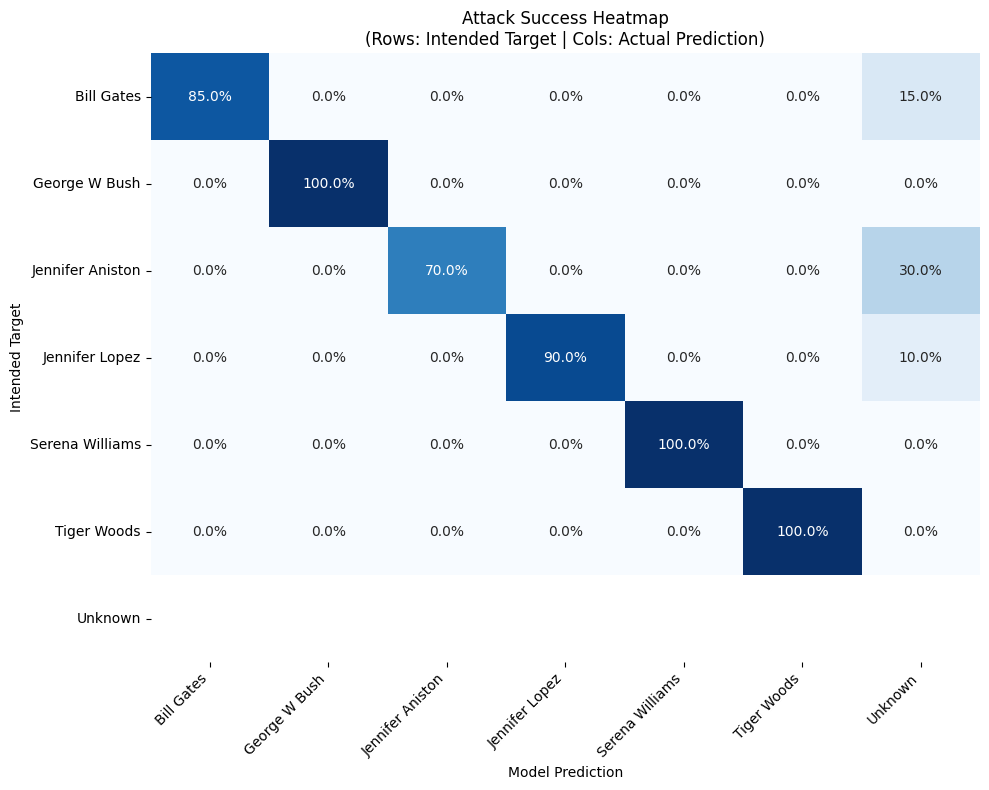

/tmp/ipython-input-612829006.py:177: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Cosine Similarity', data=plot_data,


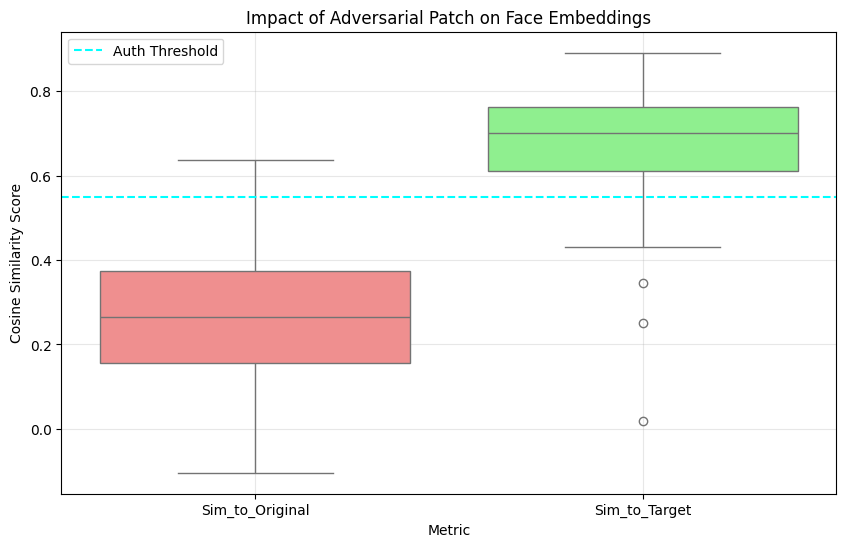

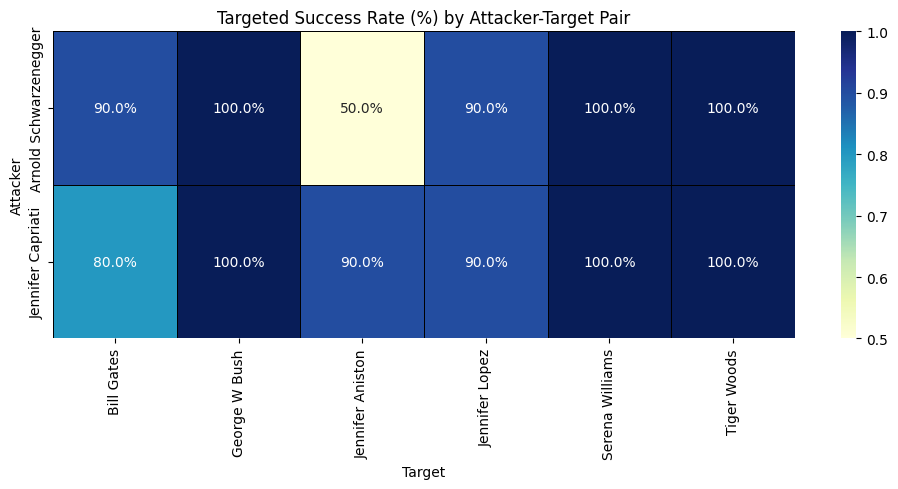

In [ ]:
# ============================================================================
# CELL 10: Quantitative Analysis & Rubric Metrics
# ============================================================================

import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm # Ensure tqdm is imported

print("\n" + "="*70)
print("GENERATING PROJECT ARTIFACTS & METRICS")
print("="*70)

# Registry for granular data
inference_data = []

print("Running comprehensive evaluation on all patches...")

# ----------------------------------------------------------------------------
# 1. Data Collection Loop
# ----------------------------------------------------------------------------
# Get a mapping of employee names to their tensor embeddings for quick lookup
name_to_emb = {
    name: employee_embeddings[f"Employee_{i+1}"]
    for i, name in enumerate(employee_names)
}

for res in tqdm(batch_results, desc="Evaluating"):
    attacker_name = res['attacker']
    target_name = res['target'] # The intended impersonation target

    # Load patch data
    filename = f"batch_exports/{attacker_name.replace(' ', '_')}_VS_{target_name.replace(' ', '_')}.pt"
    if not os.path.exists(filename):
        print(f"Warning: Patch file not found for {attacker_name} vs {target_name}")
        continue

    data = torch.load(filename)
    patch = data['patch'].to(device)
    px, py = data['x'], data['y']

    # Get Target Embedding (The Goal)
    target_emb = name_to_emb[target_name].view(1, -1)

    # Get Attacker Images
    att_id = find_person_id(attacker_name, target_names)
    imgs = get_images_for_person(att_id, images, targets)

    # Use the same test set as optimization
    num_train = CONFIG['attacker_train_images']
    num_test = CONFIG['attacker_test_images']
    test_imgs = imgs[num_train:num_train + num_test]

    # Get Original Attacker Embedding (The Baseline) - Calculated from test set
    valid_faces = [mtcnn(img) for img in test_imgs if mtcnn(img) is not None]
    if not valid_faces: continue # Skip if no faces found

    att_imgs_tensor = torch.stack(valid_faces).to(device)

    with torch.no_grad():
        # Get mean embedding of the attacker's test faces without the patch
        att_base_emb = face_model(att_imgs_tensor).mean(dim=0).view(1, -1)

    # Patch Size/Mask
    patch_size = CONFIG['patch_radius'] * 2
    mask = create_circular_mask(patch_size, CONFIG['patch_radius'], device)

    for img in test_imgs:
        face = mtcnn(img)
        if face is None: continue
        face = face.to(device)

        # Apply Patch
        patched_face = apply_circular_patch(face, patch, px, py, mask)
        face_patched_tensor = patched_face.unsqueeze(0)

        # Inference
        with torch.no_grad():
            emb = face_model(face_patched_tensor) # Shape [1, 512]

        # --- Similarity Calculations ---

        # 1. Similarity to Target
        sim_target = F.cosine_similarity(emb, target_emb).item()

        # 2. Similarity to Original Self (Baseline)
        sim_original = F.cosine_similarity(emb, att_base_emb).item()

        # 3. Final Classification
        max_sim = -1
        pred_label = "Unknown"

        # Loop over ALL potential employee targets in the database
        for emp_name in employee_names:
            emp_emb = name_to_emb[emp_name].view(1, -1)
            s = F.cosine_similarity(emb, emp_emb).item()

            if s > max_sim:
                max_sim = s
                # Only classify if confidence exceeds the threshold
                if s > CONFIG['classification_threshold']:
                    pred_label = emp_name

        # Determine Success Metric
        is_targeted_success = 1 if pred_label == target_name else 0

        # Store Record
        inference_data.append({
            'Attacker': attacker_name,
            'Target': target_name,
            'True_Label': attacker_name, # The actual identity of the person in the image
            'Predicted_Label': pred_label, # What the model thinks it is
            'Sim_to_Target': sim_target,
            'Sim_to_Original': sim_original,
            'Success_Targeted': is_targeted_success,
        })

# Convert to DataFrame for Analysis
df = pd.DataFrame(inference_data)

if df.empty:
    print("⚠️ No inference data collected. Check image paths/face detection.")
else:
    # ----------------------------------------------------------------------------
    # 2. Project Metrics Report
    # ----------------------------------------------------------------------------
    print("\n" + "="*40)
    print("QUANTITATIVE EVALUATION REPORT")
    print("="*40)

    # Calculate metrics
    avg_targeted_success = df['Success_Targeted'].mean() * 100
    avg_conf_target = df['Sim_to_Target'].mean()
    avg_conf_original = df['Sim_to_Original'].mean()

    print(f"1. ATTACK EFFECTIVENESS:")
    print(f"   - Targeted Success Rate (TSR):   {avg_targeted_success:.1f}%")
    print(f"     (Percentage of time the attacker successfully impersonated the specific target)")

    print(f"\n2. EMBEDDING SPACE SHIFT:")
    print(f"   - Mean Similarity to Target:     {avg_conf_target:.3f} (Goal: > {CONFIG['classification_threshold']})")
    print(f"   - Mean Similarity to Original:   {avg_conf_original:.3f} (Goal: Low)")

    # ----------------------------------------------------------------------------
    # 3. Visualizations
    # ----------------------------------------------------------------------------

    # A. Confusion Matrix
    plt.figure(figsize=(10, 8))
    # Collect all unique labels (Targets and Predicted) for the axis
    labels = sorted(list(set(df['Target'].unique()) | set(df['Predicted_Label'].unique())))
    # Ensure 'Unknown' is last if present
    if 'Unknown' in labels:
        labels.remove('Unknown')
        labels.append('Unknown')

    cm = confusion_matrix(df['Target'], df['Predicted_Label'], labels=labels)

    # Calculate percentages for better readability in the heatmap
    # Note: Using Target (Intended) as the row basis here.
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='Blues',
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.title('Attack Success Heatmap\n(Rows: Intended Target | Cols: Actual Prediction)')
    plt.ylabel('Intended Target')
    plt.xlabel('Model Prediction')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # B. Confidence Shift Boxplot
    plt.figure(figsize=(10, 6))
    plot_data = pd.melt(df, value_vars=['Sim_to_Original', 'Sim_to_Target'],
                        var_name='Metric', value_name='Cosine Similarity')
    sns.boxplot(x='Metric', y='Cosine Similarity', data=plot_data,
                palette={'Sim_to_Original': '#ff7f7f', 'Sim_to_Target': '#7fff7f'})
    plt.axhline(y=CONFIG['classification_threshold'], color='cyan', linestyle='--', label='Auth Threshold')
    plt.title('Impact of Adversarial Patch on Face Embeddings')
    plt.ylabel('Cosine Similarity Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # C. Success by Attacker/Target Pair
    pivot_table = df.pivot_table(index='Attacker', columns='Target',
                                 values='Success_Targeted', aggfunc='mean')
    plt.figure(figsize=(10, 5))
    sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.1%',
                linewidths=.5, linecolor='black')
    plt.title('Targeted Success Rate (%) by Attacker-Target Pair')
    plt.tight_layout()
    plt.show()